<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Гулькин Иван Сергеевич

**Забавный факт о себе:** Я хочу уйти и ИАДа, но ИАД не хочет, чтобы я с него уходил.

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [61]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [62]:
import gdown

# url = "https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing"
url = "https://drive.google.com/drive/folders/19H_cuIohs_w3MpbSHiajkV1GFpf3CaN5?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)


['/content/news_data/ria_news.tsv',
 '/content/news_data/vk_comments_w_sentiment.csv',
 '/content/news_data/vk_comments.tsv',
 '/content/news_data/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [63]:
df_ria = pd.read_csv('news_data/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [64]:
df_vk = pd.read_csv('news_data/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [65]:
df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-65-9f937a17e540>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [66]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [67]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [68]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [69]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [70]:
df_ria.target_tags.values[:3]

array([list([926, 1301, 502]), list([1232, 1393, 502]), list([1332])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [71]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [73]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [74]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [75]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [76]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [77]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [78]:
# your code here
df_vk['title_clean'] = df_vk.title.apply(normalise_text)

df_vk['snippet_clean'] = df_vk.snippet.apply(lambda x: normalise_text(x) if not pd.isnull(x) else "#UNK#")
df_ria['snippet_clean'] = df_ria.snippet.apply(lambda x: normalise_text(x) if not pd.isnull(x) else "#UNK#")

df_vk[['title_clean', 'snippet_clean']].head()
df_ria[['title_clean', 'snippet_clean']].head()

,title_clean,snippet_clean
0,нетаньяху не собирается в отставку в случае пр...,премьерминистр израиля биньямин нетаньяху не н...
1,макрон в новогоднем обращении затронул тему ре...,результат реформ не может быть мгновенным заяв...
4,пятая ракетка мира дель потро пропустит открыт...,аргентинский теннисист хуан мартин дель потро ...
5,сми кевину спейси не разрешили отсутствовать н...,суд в американском штате массачусетс отверг хо...
6,зимняя классика нхл в 2020 году пройдет в далл...,зимняя классика матч регулярного чемпионата н...


## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [79]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [80]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [81]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [82]:
df.date.dtype

dtype('O')

In [83]:
df.date = pd.to_datetime(df.date)
df.date.dtype

<ipython-input-83-06c54fbe14bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date = pd.to_datetime(df.date)


dtype('<M8[ns]')

In [84]:
# your code here
test_start_date = '2018-12-01'
test_end_date = '2018-12-31'

val_start_date = '2018-10-01'
val_end_date = '2018-11-30'

df_test = df[(df.date >= test_start_date) & (df.date <= test_end_date)]
df_val = df[(df.date >= val_start_date) & (df.date <= val_end_date)]
df_train = df[df.date < val_start_date]

df_test.shape, df_val.shape, df_train.shape

((20176, 12), (43258, 12), (136875, 12))

Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [85]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[68, 743]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[1182, 502]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[1303, 644]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[157]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[405, 502]"


Напишем датасет для поставки данных в нейросеть.


In [86]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        return (self.X_title[idx, :], self.y[idx])


__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [87]:
class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)

       self.X_snippet = None
       if snippet is not None:
        self.X_snippet = self.create_text(snippet, max_snippet_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if self.X_snippet is None:
            return (self.X_title[idx, :], self.y[idx])
        return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [88]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [89]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [90]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [91]:
!pip3 install pytorch_lightning

In [92]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

Залоггируем обучение

In [93]:
# !pip install wandb

In [94]:
# import wandb

# wandb.login()
# wandb.init(project='iad-ht-4', name='titled')

Обучим модель.

In [95]:
# from pytorch_lightning.loggers import WandbLogger

# wandb_logger = WandbLogger(log_model='all')

In [96]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

In [97]:
# wandb.watch(model_baseline)

In [ ]:
# trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x7c8399172440>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 5232) is killed by signal: Killed. 


Training: |          | 0/? [00:00<?, ?it/s]

__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [ ]:
class SnippetSimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding_title = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_snippet = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, output_dim)

    def forward(self, title, snippet=None):
        embedded_title = self.embedding_title(title)
        embedded_title = embedded_title.mean(dim=1)
        if snippet is None:
            return self.fc(embedded_title)

        embedded_snippet = self.embedding_snippet(snippet)
        embedded_snippet = embedded_snippet.mean(dim=1)
        return self.fc(torch.cat((embedded_title, embedded_snippet), dim=1))

In [ ]:
class SnippetTrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title, snippet=None):
        result = self.model(title, snippet)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, snippet, target = train_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, snippet, target = val_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

In [ ]:
NEW_VOCAB_SIZE = 30000
MAX_SNIPPET_LEN = 200

# объявляем датасеты
new_train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, NEW_VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_train.snippet_clean.values, MAX_SNIPPET_LEN)
new_val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, NEW_VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_val.snippet_clean.values, MAX_SNIPPET_LEN)
new_test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, NEW_VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_test.snippet_clean.values, MAX_SNIPPET_LEN)

In [ ]:
new_train_dataloader = DataLoader(new_train_dataset, shuffle=True, batch_size=64, num_workers=4)
new_val_dataloader = DataLoader(new_val_dataset, shuffle=False, batch_size=4096, num_workers=4)

In [ ]:
model = SnippetSimpleClassifier(NEW_VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module = SnippetTrainLightningModule(model, LR, criterion)

In [ ]:
# wandb_logger = WandbLogger(log_model='all')
# wandb.init(project='iad-ht-4', name='titled-snippet')
# wandb.watch(model)

In [ ]:
# trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, new_train_dataloader, new_val_dataloader)

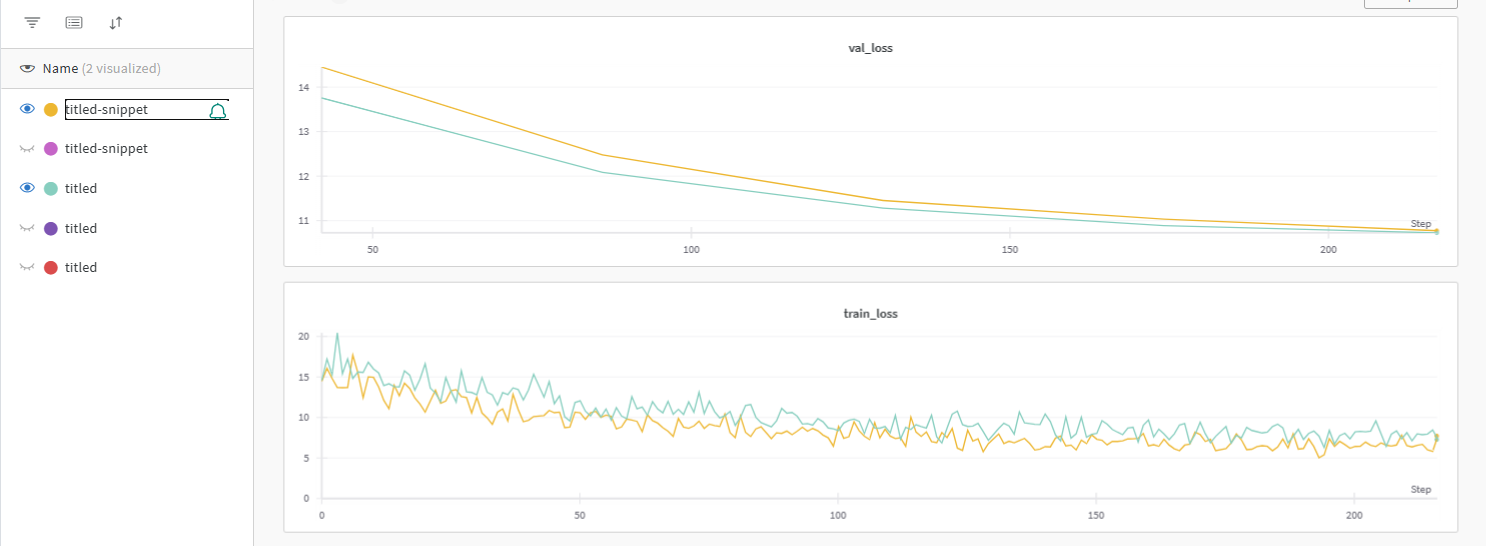

Судя по графикам, у модели, использующей сниппеты ошибка при обучении ниже, но при валидации – выше. Это может говорить о переобучении новой модели.

## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [ ]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, target in test_dataloader:
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

In [ ]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

In [ ]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [ ]:
def get_predict(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=32)

    if dataset[0].__len__() == 2:
      for title, target in dataloader:
          logit = model(title)
          pred_prob = F.softmax(logit, dim=1)
    else:
      for title, snippet, target in dataloader:
          logit = model(title, snippet)
          pred_prob = F.softmax(logit, dim=1)

    # print(pred_prob.shape)
    # assert pred_prob.shape[0] == 32
    return pred_prob, target

In [ ]:
dataloader = DataLoader(new_train_dataset, shuffle=False, batch_size=4096)
b = next(iter(dataloader))

In [ ]:
tl, sn, tg = b

In [ ]:
lg = model(tl, sn)
pp = F.softmax(lg, dim=1)
pp.shape

In [ ]:
del dataloader

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__в данной задаче важнее precision, так как если мы будем максимизировать нахождение всех верных ответов, не смотря на точность, то очень много ощибок будет допущено.

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

Функция по нахождению порога

In [ ]:
np.linspace(0, 0.05)

In [ ]:
# your code here
def find_optimal_threshold(model, dataloader):
    best_threshold = 0
    best_metric = 0
    for threshold in tqdm(np.linspace(0, 0.1, num=10)):
        for title, target in dataloader:
            logit = model(title)
            pred_prob = F.softmax(logit, dim=1)
            y_pred = 1 * (pred_prob > threshold)

            metric = precision(target, y_pred)

            if metric > best_metric:
                best_metric = metric
                best_threshold = threshold

    return best_threshold, best_metric

Подбор порога на валидационной выборке

In [ ]:
dataloader = DataLoader(val_dataset, shuffle=False, batch_size=36, num_workers=4)

In [ ]:
optimal_threshold, best_metric = find_optimal_threshold(model_baseline, dataloader)
optimal_threshold, best_metric

In [ ]:
del dataloader

Сравнение на тестовой выборке

In [ ]:
pred_prob_snip, target_snip = get_predict(model, new_test_dataset)
pred_prob_base, target_base = get_predict(model_baseline, test_dataset)

In [ ]:
y_pred_with_snippet = pred_prob_snip > optimal_threshold
y_pred_without_snippet = pred_prob_base > optimal_threshold

In [ ]:
metrik_with_snippet = precision(target_snip, y_pred_with_snippet)
metrik_without_snippet = precision(target_base, y_pred_without_snippet)

print(f"Optimal Threshold with Snippet: {optimal_threshold}")
print(f"Best metrik with Snippet: {best_metric}")
print(f"Metrik with Snippet on Test Data: {metrik_with_snippet}")
print(f"Metrik without Snippet on Test Data: {metrik_without_snippet}")

Лучше оказалась модель со сниппетами.

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
df_oob.head()

In [ ]:
# your code here
dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

pred_prob, target = get_predict(model_baseline, dataset)
pred = pred_prob > optimal_threshold
precision(target, pred)

In [ ]:
target

Точность оказалась ниже 50%.

## 1.6 Бонусное задание

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# (⊙_⊙)

__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# =^･ｪ･^=

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# ٩(ˊ〇ˋ*)و


Сравните все обученные модели между собой на тестовой выборке.

In [ ]:
# your code here
# (⌐■_■)

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
# new function to get all predictions
def get_predict(model, dataset):
    preds = []
    targets = []
    dataloader = DataLoader(dataset, shuffle=False, batch_size=16)

    if dataset[0].__len__() == 2:
      for title, target in dataloader:
          logit = model(title)
          pred_prob = F.softmax(logit, dim=1)
          preds.append(pred_prob)
          targets.append(target)
    else:
      for title, snippet, target in dataloader:
          logit = model(title, snippet)
          pred_prob = F.softmax(logit, dim=1)
          preds.append(pred_prob)
          targets.append(target)

    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)

    return preds, targets

In [ ]:
df_vk.columns

In [ ]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]

vk_dataset = NewsDataset(df_vk.target_tags.values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_vk.snippet_clean.values, MAX_SNIPPET_LEN)
pred_prob_vk, target_vk = get_predict(model, vk_dataset)

df_vk['target_tags'] = pred_prob_vk

На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [ ]:
# Ваш код с сохранением данных

# your code here
# ¯\_(ツ)_/¯

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [43]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели? – seara.
2. Как выглядит архитектура модели? Насколько модель большая? – 29.4M params, supported sequences: 2048, vocabulary: 83828 tokens.
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?
<br>
This is RuBERT-tiny2 model fine-tuned for sentiment classification of short Russian texts. – вполне адекватно, так как комментарии тоже короткие и тоже нужен сентимент-анализ.
<br>
This model was trained on the union of the following datasets:
Kaggle Russian News Dataset
Linis Crowd 2015
Linis Crowd 2016
RuReviews
RuSentiment

Установим библиотеку. 🤗🤗🤗

In [44]:
!pip3 install transformers

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [45]:
from transformers import pipeline

model = pipeline(model="seara/rubert-tiny2-russian-sentiment", device=device)
model('Хочу все сдать')

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': 'positive', 'score': 0.8102167248725891}]

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [46]:
df_comments.iloc[:10, :].text.apply(lambda x: model(x)[0]['label'])
df_comments.iloc[:10, :]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0
5,24006379.0,24006362.0,2019-02-01 23:18:00,"[id109937745|Илья], Донецкая Народная Республи...",3.0
6,24006380.0,24006362.0,2019-02-01 23:18:44,"[id89551382|Юрий], это где?",2.0
7,24006381.0,24006362.0,2019-02-01 23:18:55,"[id109937745|Илья], Донецкая Народная Республика.",1.0
8,24006383.0,24006362.0,2019-02-01 23:20:00,"[id483059794|Марк], Донецк российский отделилс...",0.0
9,24006384.0,24006362.0,2019-02-01 23:20:22,"[id109937745|Илья], на планете Земля.",0.0


In [47]:
# df_comments['sentiment_verdict'] = df_comments.text.apply(lambda x: model(x)[0]['label'])
# df_comments['sentiment_score'] = df_comments.text.apply(lambda x: model(x)[0]['score'])

# <ваш код для сохранения данных>

# P.S. Код для скоринга комментариев работает довольно долго. Первый, кто проскорит всю базу, может поделиться ей в общем чате с однокурсниками
# Если вы используете эту базу, просто продемонстрируйте при решении этого пункта, что ваш код работает
df_comments = pd.read_csv('./news_data/vk_comments_w_sentiment.csv').iloc[:, 1:]
df_comments.head()

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223


## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [48]:
pos_ratio = df_comments[df_comments.sentiment_verdict == 'positive'].__len__() / df_comments.__len__()
pos_ratio

0.07173770175558795

In [49]:
neg_ratio = df_comments[df_comments.sentiment_verdict == 'negative'].__len__() / df_comments.__len__()
neg_ratio

0.22334323013332547

In [50]:
df_comments[df_comments.sentiment_verdict == 'positive'].sort_values('sentiment_score', ascending=False).iloc[:10, :]['text'].tolist()

['Отлично, молодец!Поздравляю!✨💫🌟💥',
 'Отлично! Просто отлично! Молодцы! Поздравляю от души! Горжусь!',
 'отлично,молодцы!!!👍 респект',
 'Отлично! \nПоздравляем!!!',
 'Отлично,я рад.',
 'Отлично,молодцы',
 'Отлично,люблю ездить в Эмираты',
 'Отлично! Здоровья всем желаю!',
 'Я очень счастлива! Поздравляю!',
 'Отлично, просто отлично!']

In [ ]:
df_comments[df_comments.sentiment_verdict == 'negative'].sort_values('sentiment_score', ascending=False).iloc[:10, :]['text']

__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [54]:
positive_counts = df_comments[df_comments.sentiment_verdict == 'positive'].groupby('post_id').size()
negative_counts = df_comments[df_comments.sentiment_verdict == 'negative'].groupby('post_id').size()
positive_counts

post_id
17976037.0    12
17976198.0     1
17976766.0     8
17976905.0     4
17977107.0     2
              ..
24005764.0    10
24005972.0     2
24006100.0     3
24006240.0     3
24006362.0     2
Length: 19387, dtype: int64

In [55]:
df_vk['neg_count'] = [0] * df_vk.shape[0]
df_vk['pos_count'] = [0] * df_vk.shape[0]

for i, row in tqdm(df_vk.iterrows()):
    post_id = row['id']
    if post_id in positive_counts:
        df_vk.loc[i, 'pos_count'] = positive_counts[post_id]
    if post_id in negative_counts:
        df_vk.loc[i, 'neg_count'] = negative_counts[post_id]

df_vk

0it [00:00, ?it/s]

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,neg_count,pos_count
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,10,2
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,12,3
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,4,3
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,8,2
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,37,10
...,...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...,#UNK#,30,4
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...,#UNK#,11,8
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...,#UNK#,11,0
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу,#UNK#,10,1


__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

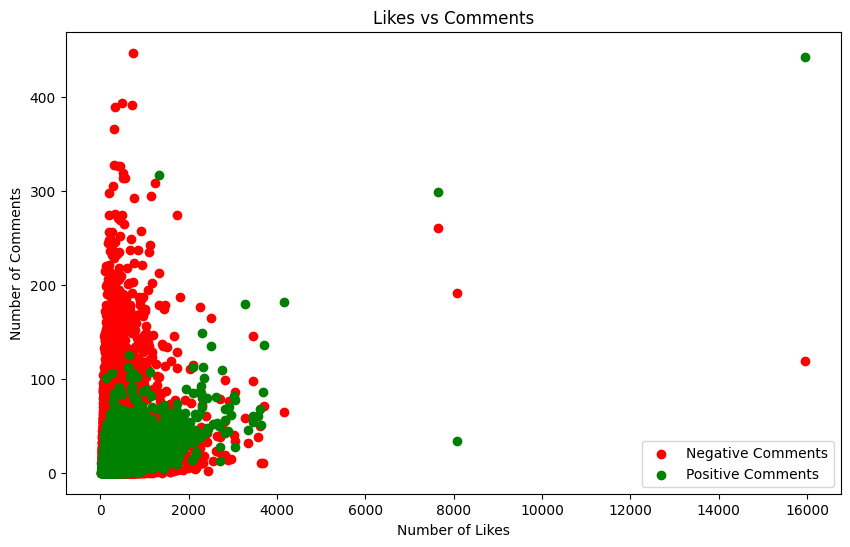

In [56]:
import matplotlib.pyplot as plt

filtered_df = df_vk[df_vk['likes'] > 0]

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['likes'], filtered_df['neg_count'], color='red', label='Negative Comments')
plt.scatter(filtered_df['likes'], filtered_df['pos_count'], color='green', label='Positive Comments')
plt.xlabel('Number of Likes')
plt.ylabel('Number of Comments')
plt.title('Likes vs Comments')
plt.legend()
plt.show()

#### Результаты
1. Новости с большим числом лайков получают больше позитивных комментов (правый верхний кружок).
2. Чем меньше лайков, тем больше негатива (правая часть от 0 до 2к лайков).
3. Не всегда чем больше комментов, тем больше лайков: самый закомментированный пост имеет лайки в диапазоне от 0 до 2к.

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [57]:
def calculate_lower_bound(u, d):
    a = 1 + u
    b = 1 + d
    lower_bound = (a / (a + b)) - (1.65 * ((a * b) / ((a + b) ** 2 * (a + b + 1))) ** 0.5)
    return lower_bound

df_vk['lower_bound'] = df_vk.apply(lambda row: calculate_lower_bound(row['pos_count'], row['neg_count']), axis=1)

df_vk.sort_values('lower_bound', ascending=False).iloc[:10, :].loc[:, ['title', 'likes', 'comments', 'neg_count', 'pos_count', 'lower_bound']]

,title,likes,comments,neg_count,pos_count,lower_bound
6651,Сборная России выиграла командный турнир на че...,1387,53,0,34,0.927645
1547,Российские хоккеисты обыграли Канаду на молоде...,1235,94,1,42,0.905420
17907,Российские фигуристы Боброва и Соловьев победи...,780,47,0,22,0.892391
7572,"Россиянин Иван Бессонов победил в конкурсе ""кл...",1882,119,3,59,0.887960
19150,Российская шахматистка Александра Костенюк ста...,924,57,0,21,0.887837
13930,Вопреки всему: россияне стали вторыми на Парал...,2429,96,2,47,0.887338
8122,Кузнецов и Захаров победили в синхронных прыжк...,1163,38,0,19,0.877466
974,Россиянки выиграли золото по биатлону в эстафе...,2138,142,4,63,0.876408
14187,Российские дзюдоисты победили в медальном заче...,844,38,0,18,0.871527
3726,Тарасова и Морозов победили в соревнованиях сп...,618,37,0,18,0.871527


Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__

__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.